# Preparation for Prediction of Boreal Height in North America with CMIP6 bioclimatic variables, soil, permfrost

Paul Montesano, PhD  
paul.m.montesano@nasa.gov  

 - compile North America study domain  
 - assemble ICESat-2 ATL08 20m point observations used for generating gridded training data

In [ ]:
dir_home = ''

In [ ]:
import sys
sys.path.append(f'{dir_home}/code/geoscitools')
import atl08lib
import maplib
import pandas as pd
import geopandas as gpd
import csv
import numpy as np

import os
os.sys.path.append(f'{dir_home}/code/icesat2')
import FilterUtils
import contextily as ctx
%matplotlib inline
from plotnine import *
import glob

In [ ]:
maindir = '' #'/userfs02'
outdir =    f'{maindir}/projects/ilab/boreal_height_cmip'
data_dir =  f'{maindir}/arc'
dir_atl08 = f'{maindir}/data/icesat2/atl08.005'

# Input Extents

In [46]:
# https://databasin.org/datasets/1f624a31ab224835a78ad4bf11103419/
permaice_extent_fn = os.path.join(dat_dir, 'permaice_extent.gpkg')
continents_fn =      os.path.join(dat_dir, 'continents.shp')
wwf_circumboreal_extent_dissolved_fn = os.path.join(dat_dir, 'wwf_circumboreal_Dissolve.shp')
hydrobasins_patterns_fn = f'{outdir}/hydrobasins_L08_patterns_tte_boreal_tundra.gpkg'

# Define clip extent
Unions, dissolves, buffer, to get a clip extent and an extent in which data will be zero'd out   
Bbox + Continent + Continuous Permafrost Domain + Boreal Domain

#### Creat bbox polygon gdf

In [32]:
def make_bbox_gdf(bbox=[-180, 45, 180, 75]):
    import geopandas as gpd
    from shapely.geometry import Point, Polygon

    p1 = Point(bbox[0], bbox[3])
    p2 = Point(bbox[2], bbox[3])
    p3 = Point(bbox[2], bbox[1])
    p4 = Point(bbox[0], bbox[1])

    np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
    np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
    np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
    np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

    bb_polygon = Polygon([np1, np2, np3, np4])

    bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'], crs=4326)
    
    return bbox_gdf



In [33]:
EXT_NORTH_AMERICA = [-169, 45, -50, 75]
EXT_EURASIA = [-10, 45, 180, 75]

EXT_DICT = {'REALM': ['Palearctic', 'Nearctic'], 
            'EXTENT': [EXT_EURASIA, EXT_NORTH_AMERICA], 
            'CONTINENTS_LIST': [['Asia', 'Europe'], ['North America']],
            'EXTENT_CONT_CLIP': [],
            'EXTENT_PERM_CLIP': [],
            'EXTENT_BOREAL_BUF_CLIP': [],
            'EXTENT_BOREAL_BUF_CLIP_UNION': [],
            'EXTENT_FINAL': []
           }

### Buffer boreal

In [34]:
BUF_DIST = 1e5
print(f' Buffer distance (km): {int(BUF_DIST/1000)}')

 Buffer distance (km): 100


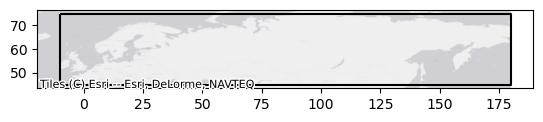

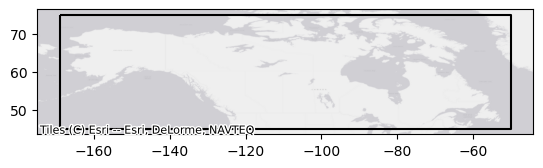

In [6]:
for EXT in EXT_DICT['EXTENT']:
    bbox_gdf = make_bbox_gdf(bbox = EXT)
    
    ax_main = bbox_gdf.boundary.plot(color='black')
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )

In [7]:
continents_gdf = gpd.read_file(continents_fn)

Explode the continents layer and find the continental polygon (the largest).   
This will effectively exclude the non-continental (islands) of the Canadian High Arctic

In [8]:
continents_gdf.head()
g = continents_gdf.groupby('CONTINENT')
g.groups.keys()

dict_keys(['Africa', 'Antarctica', 'Asia', 'Australia', 'Europe', 'North America', 'Oceania', 'South America'])

/tmp/ipykernel_4151553/3585937967.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_4151553/3585937967.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


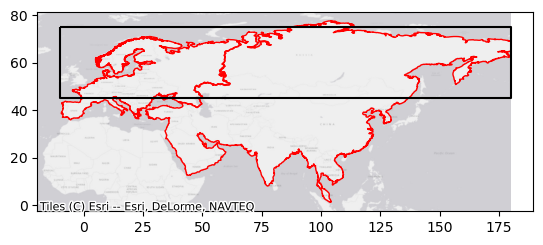

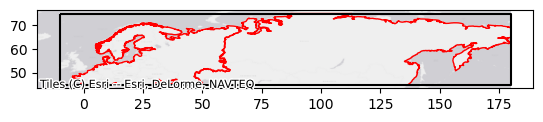

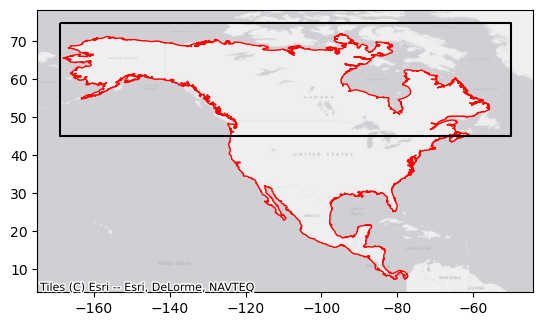

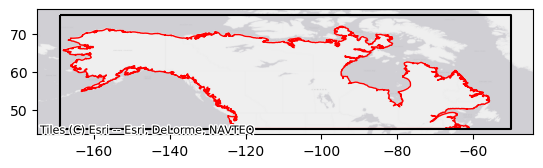

In [9]:
EXT_DICT['EXTENT_CONT_CLIP'] = []
for i, CONTINENTS_LIST in enumerate(EXT_DICT['CONTINENTS_LIST']):
    
    # This explode() step sets up the area selection step that limits us to mainlands
    # Note 3e6 area thresh removes Greenland
    sub_conts_gdf = continents_gdf[continents_gdf['CONTINENT'].isin(CONTINENTS_LIST)].explode()
    sub_conts_gdf['area_km2'] = sub_conts_gdf.to_crs(3995).area / 10**6
    sub_conts_gdf = sub_conts_gdf[sub_conts_gdf.area_km2 > 3e6].cx[EXT_DICT['EXTENT'][i][0]:EXT_DICT['EXTENT'][i][2], 45:75]

    bbox_gdf = make_bbox_gdf(bbox = EXT_DICT['EXTENT'][i])
    
    ax_main = bbox_gdf.boundary.plot(color='black')
    ax_main = sub_conts_gdf.plot(ax=ax_main, color='none', ec='red')
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    
    sub_conts_gdf_clip = gpd.overlay(sub_conts_gdf, bbox_gdf, how='intersection')
    
    ax_main = bbox_gdf.boundary.plot(color='black')
    ax_main = sub_conts_gdf_clip.plot(ax=ax_main, color='none', ec='red')
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    EXT_DICT['EXTENT_CONT_CLIP'].append(sub_conts_gdf_clip)

In [10]:
# https://databasin.org/datasets/1f624a31ab224835a78ad4bf11103419/
perma = gpd.read_file(permaice_extent_fn)
perma['NUM_CODE'] = pd.to_numeric(perma['NUM_CODE'])
perma["area_km2"] = perma['geometry'].to_crs(3995).area/ 10**6

In [11]:
boreal_gdf = gpd.read_file(wwf_circumboreal_extent_dissolved_fn).to_crs(4326)

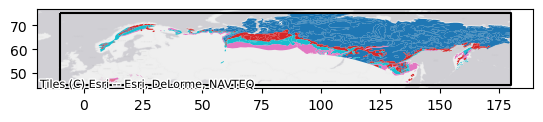

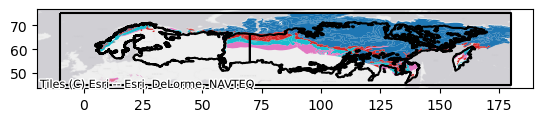

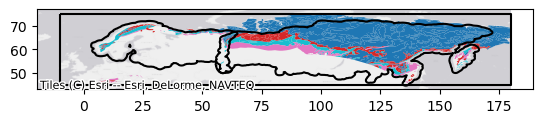

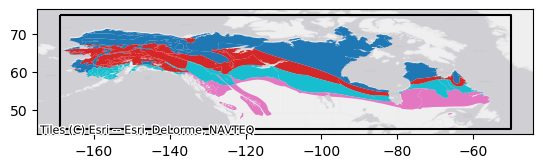

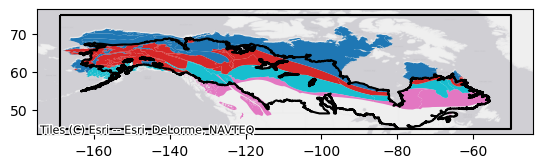

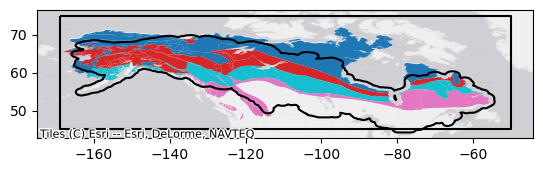

In [12]:
EXT_DICT['EXTENT_PERM_CLIP'] = []
EXT_DICT['EXTENT_BOREAL_BUF_CLIP'] = []
for i, GDF_CONT in enumerate(EXT_DICT['EXTENT_CONT_CLIP']):
    
    perma_clip = gpd.overlay(perma, GDF_CONT.to_crs(perma.crs), how='intersection')
    EXT_DICT['EXTENT_PERM_CLIP'].append(perma_clip)
    bbox_gdf = make_bbox_gdf(bbox = EXT_DICT['EXTENT'][i])
    
    ax_main = perma_clip.to_crs(4326).plot(column='EXTENT')
    ax_main = bbox_gdf.boundary.plot(color='black', ax=ax_main)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas             
        )
    
    boreal_gdf_clip = gpd.overlay(boreal_gdf, GDF_CONT.to_crs(boreal_gdf.crs), how='intersection')
    ax_main = perma_clip.to_crs(4326).plot(column='EXTENT')
    ax_main = bbox_gdf.boundary.plot(color='black', ax=ax_main)
    ax_main = boreal_gdf_clip.boundary.plot(color='black', ax=ax_main)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    
    tmp = boreal_gdf_clip.to_crs(3995)
    tmp['geometry'] = tmp.geometry.buffer(BUF_DIST)
    boreal_gdf_clip_buf = tmp.to_crs(4326)
    
    
    ax_main = perma_clip.to_crs(4326).plot(column='EXTENT')
    ax_main = bbox_gdf.boundary.plot(color='black', ax=ax_main)
    ax_main = boreal_gdf_clip_buf.boundary.plot(color='black', ax=ax_main)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    
    #boreal_gdf_clip_buf = EXT_DICT['EXTENT_BOREAL_BUF_CLIP'][i]
    boreal_gdf_clip_buf = boreal_gdf_clip_buf.drop(columns=['Shape_Leng', 'Shape_Area', 'area_km2'])
    #boreal_gdf_clip_buf = boreal_gdf_clip_buf.drop(columns=['Shape_Leng', 'Shape_Area', 'area_km2'])
    realm = EXT_DICT['REALM'][i]
    boreal_gdf_clip_buf['REALM'] = realm
    
    EXT_DICT['EXTENT_BOREAL_BUF_CLIP'].append(boreal_gdf_clip_buf)
    boreal_gdf_clip_buf.to_file(os.path.join(outdir, f'wwf_circumboreal_Dissolve_{realm}_buf{int(BUF_DIST/1000)}km.gpkg'), driver='GPKG')

# Finalize the Boreal Height CMIP6 Extent

## Union, classify, and dissolve to get final clip vector
*Boreal extent + all permafrost in continental North America*

#### Union

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:2323: UserWarning: `keep_geom_type=True` in overlay resulted in 4011 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


CPU times: user 3min 10s, sys: 631 ms, total: 3min 10s
Wall time: 3min 9s


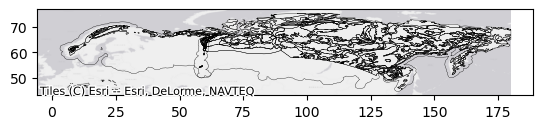

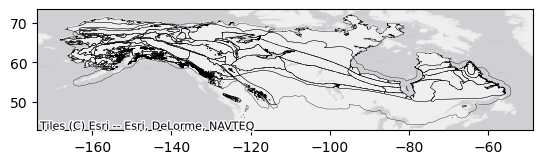

In [16]:
%%time
for i, REALM in enumerate(EXT_DICT['REALM']):
    
    perma_clip = EXT_DICT['EXTENT_PERM_CLIP'][i]
    boreal_gdf_clip_buf = EXT_DICT['EXTENT_BOREAL_BUF_CLIP'][i]
    
    # Boreal extent + all permafrost in continental North America
    boreal_gdf_clip_buf_perm = boreal_gdf_clip_buf.to_crs(4326).overlay(perma_clip.to_crs(4326), how='union')
    ax_main = boreal_gdf_clip_buf_perm.boundary.plot(ec='k', linewidth=0.25)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )
    boreal_gdf_clip_buf_perm.to_file(os.path.join(outdir, f'/wwf_circumboreal_Dissolve_{REALM}_buf{int(BUF_DIST/1000)}km_PERMEXTENT.gpkg'), driver='GPKG')

In [17]:
boreal_gdf_clip_buf_perm.tail()

,OBJECTID,REALM,CONTINENT_1,NUM_CODE,COMBO,RELICT,EXTENT,CONTENT,LANDFORM,area_km2_1,CONTINENT_2,area_km2_2,geometry
1330,NaN,NaN,NaN,17.0,Clr,None,C,l,r,1464.513906,North America,2.741632e+07,"POLYGON ((-106.80969 68.40561, -106.91899 68.3..."
1331,NaN,NaN,NaN,1.0,Chf,None,C,h,None,285818.060662,North America,2.741632e+07,"MULTIPOLYGON (((-114.77055 68.76944, -114.7583..."
1332,NaN,NaN,NaN,1.0,Chf,None,C,h,None,9164.018003,North America,2.741632e+07,"POLYGON ((-81.28969 67.42320, -81.45025 67.476..."
1333,NaN,NaN,NaN,1.0,Chf,None,C,h,None,5.298096,North America,2.741632e+07,"POLYGON ((-82.51633 69.51617, -82.50823 69.513..."
1334,NaN,NaN,NaN,17.0,Clr,None,C,l,r,1.608619,North America,2.741632e+07,"POLYGON ((-89.05291 63.95986, -89.03555 63.946..."


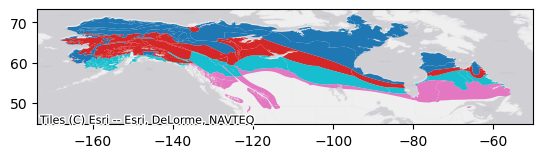

In [18]:
ax_main = boreal_gdf_clip_buf_perm.plot(column='EXTENT', linewidth=0.25)
ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

#### Classify, Dissolve, Save
the continuous permafrost extent that is not within the 100 km buffer of the boreal is where canopy height values from ATL08 will be set to 0.

In [19]:
def domain_classifier(row):
    if row["height_class"] == 'h_can':
        return "training/testing | prediction"
    elif row["height_class"] == 'h_can to 0':
        return "training/testing"
    elif row["height_class"] == 'NaN':
        return "training/testing | prediction | analysis"
    else:
        return "none"

In [20]:
EXT_DICT['EXTENT_FINAL'] = []

for REALM in EXT_DICT['REALM']:
    EXTENT_FN = f"{outdir}/boreal_height_cmip_extent_{REALM}.gpkg"
    boreal_gdf_clip_buf_perm = gpd.read_file(f'{outdir}/wwf_circumboreal_Dissolve_{REALM}_buf{int(BUF_DIST/1000)}km_PERMEXTENT.gpkg', driver='GPKG')
    condition = ((boreal_gdf_clip_buf_perm.REALM.isnull()) & (boreal_gdf_clip_buf_perm.EXTENT == 'C'))

    boreal_gdf_clip_buf_perm['height_class'] = np.where(condition, 'h_can to 0', 'h_can')
    
    extent_dis = boreal_gdf_clip_buf_perm.dissolve(by='height_class').reset_index()
    
    extent_dis = extent_dis[['geometry','height_class']]
    
    extent_dis['domain'] = extent_dis.apply(domain_classifier, axis=1)
    
    z = boreal_gdf_clip_buf[['geometry']].overlay(extent_dis, how='symmetric_difference')
    z = boreal_gdf_clip_buf[['geometry']].overlay(z, how='union')

    # Manually classify the new subset domain
    z['index_orig'] = z.index
    z.loc[z.index_orig==2,'domain'] = 'training/testing | prediction | analysis'
    z.loc[z.index_orig==2,'height_class'] = 'h_can'
    # Remove junk
    z = z[~(z.domain.isnull())]
    extent_dis = z
    
    extent_dis.to_file(EXTENT_FN, driver='GPKG')
    
    # Explode multi to single polygon
    extent_dis = extent_dis.explode().reset_index()
    extent_dis.to_file(f"{outdir}/boreal_height_cmip_extent_polygons_{REALM}.gpkg", driver='GPKG')

/tmp/ipykernel_4151553/3068529901.py:30: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:2323: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
/tmp/ipykernel_4151553/3068529901.py:30: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


In [21]:
#extent_dis.explore(column='domain', cmap='viridis',legend=True)

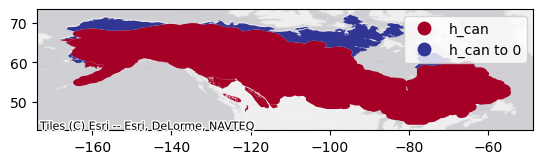

In [22]:
ax_main = extent_dis.plot(column='height_class', cmap='RdYlBu', legend=True)
ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

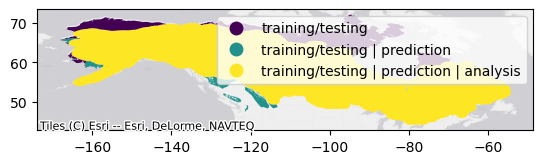

In [209]:
ax_main = extent_dis.plot(column='domain', cmap='viridis', legend=True)
ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

In [23]:
extent_dis.head()

,level_0,level_1,height_class,domain,index_orig,geometry
0,1,0,h_can to 0,training/testing,1,"POLYGON ((-143.89264 69.22440, -144.04470 69.2..."
1,1,1,h_can to 0,training/testing,1,"POLYGON ((-143.75615 69.23161, -143.75615 69.2..."
2,2,0,h_can,training/testing | prediction | analysis,2,"POLYGON ((-80.42452 44.29109, -80.51295 44.322..."
3,4,0,h_can,training/testing | prediction,4,"POLYGON ((-63.12904 58.72807, -62.98480 58.775..."
4,4,1,h_can,training/testing | prediction,4,"POLYGON ((-69.12979 45.91326, -69.14877 45.927..."


### Modify with hydrobasins dissolve 

In [24]:
hydrobasins_patterns = gpd.read_file(hydrobasins_patterns_fn)

In [25]:
#hydrobasins_patterns.cx[-60:-50,45:60].explore()

In [26]:
hydrobasins_extent = hydrobasins_patterns.dissolve()

In [27]:
hydrobasins_extent = hydrobasins_extent.explode().drop(['HYBAS_ID', 'pattern_class'], axis=1).reset_index()

/tmp/ipykernel_4151553/4120785839.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


In [28]:
hydrobasins_extent = hydrobasins_extent.to_crs(3857)

In [29]:
hydrobasins_extent["area_sq_km"] = hydrobasins_extent['geometry'].area/ 10**6

In [30]:
hydrobasins_extent = hydrobasins_extent.iloc[
   hydrobasins_extent.area_sq_km.argsort().values
]

### Add small BOREAL poly outliers that are separated from the main BOREAL Study Domain
These are part of the `prediction | analysis` domain of the Study Domain - need these to update Figure 2 map of manuscript.  
After sorting by size, N=19 brings in the tip of Prince Edward Island

In [ ]:
N=19
study_domain_additions = hydrobasins_extent.tail(N).head(N-1).to_crs(4326).drop('area_sq_km', axis=1)
study_domain_additions.explore()

In [ ]:
study_domain_additions['height_class'] = 'h_can'
study_domain_additions['domain'] = 'prediction | analysis'
study_domain_additions['index_orig'] = 'NA'
study_domain_additions.head()

In [ ]:
m = extent_dis.explore(column='height_class', cmap='RdYlBu', legend=True)
study_domain_additions.explore(m=m, color='green')

## Update Study Domain

In [ ]:
extent_dis_update = pd.concat([study_domain_additions, extent_dis]).dissolve(by='domain').reset_index().drop('index_orig', axis=1)
extent_dis_update

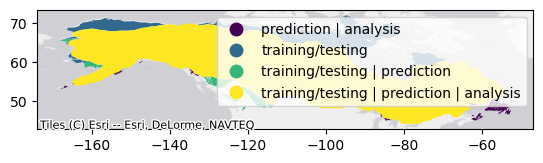

In [72]:
ax_main = extent_dis_update.plot(column='domain', cmap='viridis', legend=True)
ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

## Write out Study Domain used in this study

In [76]:
extent_dis_update.to_file(f"{outdir}/boreal_height_cmip_extent_polygons_{REALM}_update.gpkg", driver='GPKG')

# Intersect ATL08 with Study Domain extent

#### Build ATL08 geodataframe from extracted CSVs that were heavily filtered with land-cover specific thresholds for h_can (canopy height)

In [1]:
SITENAME = 'boreal_na_20m'
minYEAR = 2018
maxYEAR = 2022

# Filter: using land cover specific thresholds

In [28]:
class_thresholds_hcan =     [0,60,60,60,60,60,60,50,50,50,50,50,50,20,10,10,5,5,0,0,0,0,0]
class_thresholds_hcan_new = [0,60,60,60,60,60,60,50,50,50,50,50,50, 5, 5, 5,5,5,0,0,0,0,0]


class_values = [ 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200] 
class_names = ['No data', 'Closed forest\nevergreen needle', 'Closed forest\ndeciduous needle', 'Closed forest\nevergreen broad', 'Closed forest\ndeciduous broad', 'Closed forest\nmixed', 'Closed forest\nunknown', 
               'Open forest\nevergreen needle', 'Open forest\ndeciduous needle', 'Open forest\nevergreen_broad', 'Open forest\ndeciduous_broad', 'Open forest\nmixed', 'Open forest\nunknown', 'Shrubs', 'Herbaceous', 
               'Herbaceous\nwetleand', 'Moss/lichen', 'Bare/sparse', 'Cultivated/managed', 'Urban/built', 'Snow/ice', 'Permanent\nwater', 'Open sea']
class_names = ['No data', 'Closed forest evergreen needle', 'Closed forest deciduous needle', 'Closed forest evergreen broad', 'Closed forest deciduous broad', 'Closed forest mixed', 'Closed forest unknown', 
               'Open forest evergreen needle', 'Open forest deciduous needle', 'Open forest evergreen_broad', 'Open forest deciduous_broad', 'Open forest mixed', 'Open forest unknown', 'Shrubs', 'Herbaceous', 
               'Herbaceous wetleand', 'Moss/lichen', 'Bare/sparse', 'Cultivated/managed', 'Urban/built', 'Snow/ice', 'Permanent water', 'Open sea']

# Make dicts
landcover_remap_dict = dict(zip(class_values, class_names))
threshold_remap_dict = dict(zip(class_names, class_thresholds_hcan_new))
dict_lc_h_can_thresh = dict(zip(class_values, class_thresholds_hcan_new))

In [27]:
print("{:<40} {:<0}".format('Landcover Class','Canopy Height Threshold (m) '))
for classname, thresh in threshold_remap_dict.items():
    print("{:<40} {:<0}".format(classname, thresh))

Landcover Class                          Canopy Height Threshold (m) 
No data                                  0
Closed forest evergreen needle           60
Closed forest deciduous needle           60
Closed forest evergreen broad            60
Closed forest deciduous broad            60
Closed forest mixed                      60
Closed forest unknown                    60
Open forest evergreen needle             50
Open forest deciduous needle             50
Open forest evergreen_broad              50
Open forest deciduous_broad              50
Open forest mixed                        50
Open forest unknown                      50
Shrubs                                   5
Herbaceous                               5
Herbaceous wetleand                      5
Moss/lichen                              5
Bare/sparse                              5
Cultivated/managed                       0
Urban/built                              0
Snow/ice                                 0
Permanent water

# Read, Intersect, Filter, Save

In [ ]:
%%time
main_dir = f'{dir_atl08}/{SITENAME}'

# Read, Intersect
atl08_gdf = pd.concat([atl08lib.atl08_io(main_dir, str(YEAR), DO_PICKLE=False, LENGTH_SEG=20, INTERSECT=EXTENT_FN) for YEAR in range(minYEAR, maxYEAR+1)])

# Filter with dicts
atl08_gdf = pd.concat([atl08_gdf[(atl08_gdf.seg_landcov == lc) & (atl08_gdf.h_can_20m < thresh_h_can)] for lc, thresh_h_can in dict_lc_h_can_thresh.items()])

# Save
out_parquet_fn = f"{outdir}/atl08_{SITENAME}_intersect_filt_{minYEAR}_{maxYEAR}.parquet"
atl08_gdf.to_parquet(out_parquet_fn) 

print(f'/n{out_parquet_fn}')

atl08_gdf.info()

## Get total ATL08 20m obs across all years

In [38]:
list_atl08_fn = glob.glob(outdir + '/atl08_boreal_na_20m_intersect_filt_20*_20*.parquet')
total_obs = 0
gdf_list = []
for fn in list_atl08_fn:
    gdf = gpd.read_parquet(fn)
    gdf_list.append(gdf)
    print(gdf.shape)
    total_obs += gdf.shape[0]

(4843345, 26)
(7361111, 26)
(3422527, 26)
(4248609, 26)


In [39]:
total_obs

19875592

## Write out all ATL08 used in this study

In [43]:
pd.concat(gdf_list).to_parquet(os.path.join(outdir, 'atl08_boreal_na_20m_intersect_filt_2018-2022.parquet'))

# Map

In [ ]:
atl08_gdf.sample(frac=0.01).explore(column='height_class', cmap='RdYlBu', 
                   tiles = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                   #tiles = 'http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}',
                   attr =' ')

In [ ]:
%%time
SAMP_FRAC=0.01
maplib.MAP_ATL08_FOLIUM(atl08_gdf.cx[-130:-128, 66:70].sample(frac=SAMP_FRAC), MAP_COL='h_can_20', GROUP_COL='y', DO_NIGHT=False, RADIUS=3)